In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [28]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 15
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[2*X[0] - 1, 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

In [29]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [30]:
def plot_graph(ts, m, P, t, x_exact, x_lim=None, y_lim=None):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')
    if x_lim != None:
        plt.xlim(x_lim)
    if y_lim != None:
        plt.ylim(y_lim)
    plt.show()

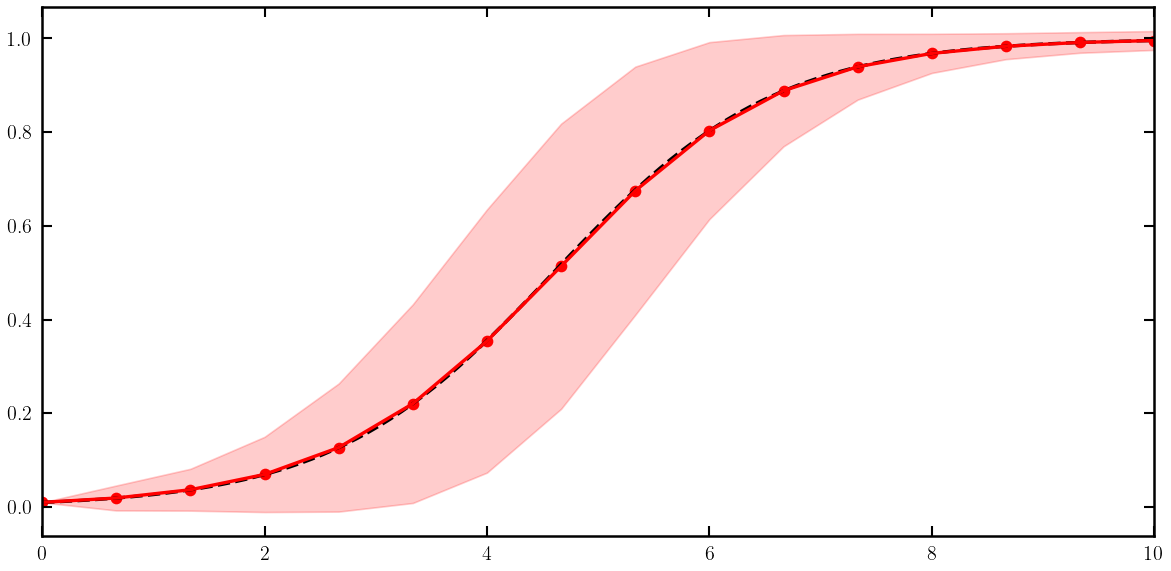

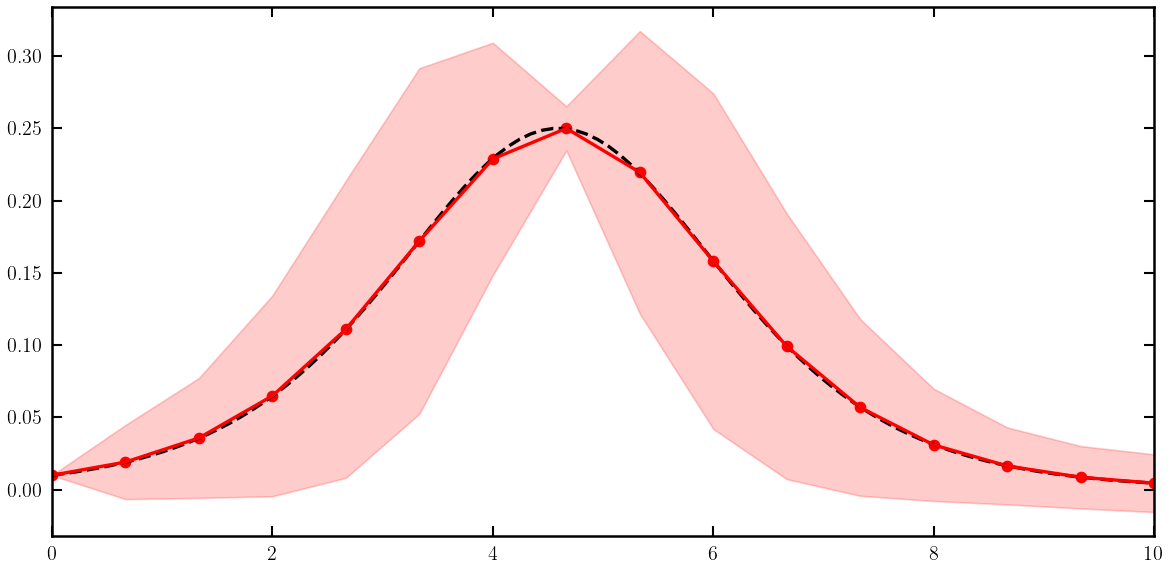

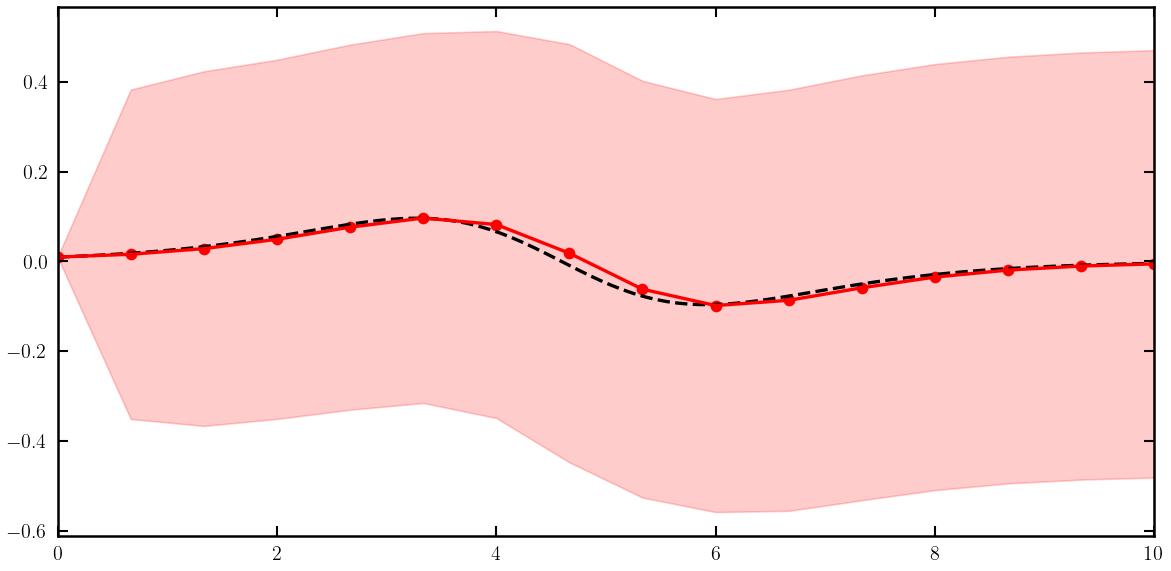

In [31]:
for k in range(3):
    plot_graph(ts, m_sequence[:,k], P_sequence[:,k,k], t, exact_sols[k],x_lim=[0,10])

### Compare stable sqr computed version with "unstable" version

as you will see here in the following, for the logistic ODE the results are identical, but they might me different for different e.g. stiff ODEs. 

In [32]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

m_sequence2, P_sequence2, m_predictions2, P_predictions2 = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [33]:
def plot_graph2(ts, m, P, m2, P2, t, x_exact):
    plt.figure(figsize=(10,5))
    plt.plot(t, x_exact(t), linestyle='--', color="black")
    plt.plot(ts, m, color='red')
    plt.scatter(ts, m, color='red')
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    plt.fill_between(ts,m-margin, m+margin, alpha=0.2, color='red')

    plt.scatter(ts, m2, color='blue')
    plt.plot(ts, m2, color='blue')
    P_f_safe2 = np.maximum(P2, 0)
    margin2 = np.sqrt(P_f_safe2)
    plt.fill_between(ts,m2-margin2, m2+margin2, alpha=0.2, color='blue')
    plt.show()

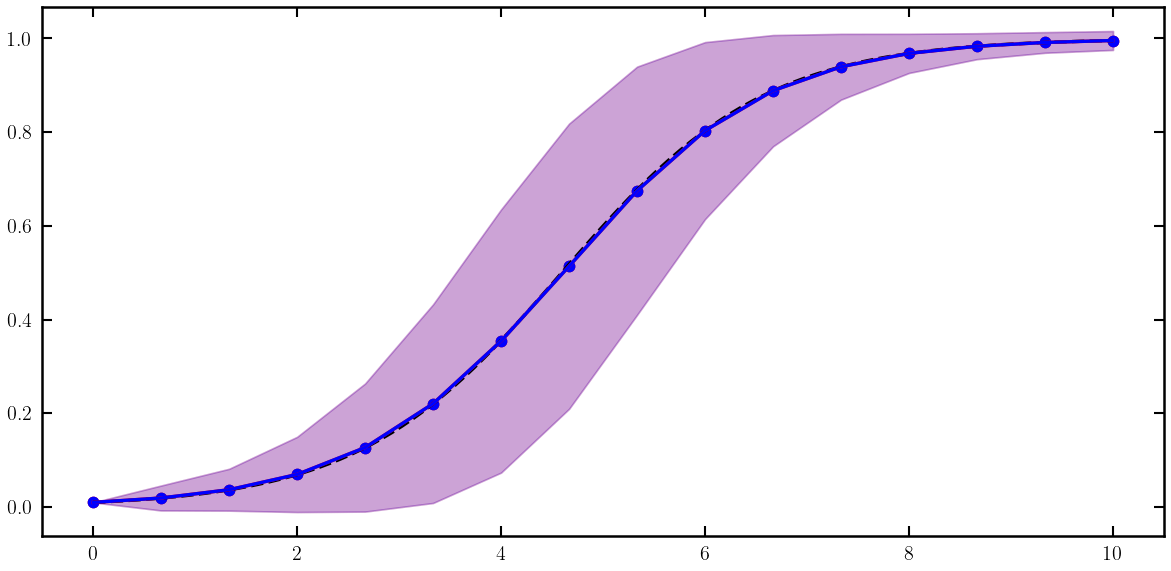

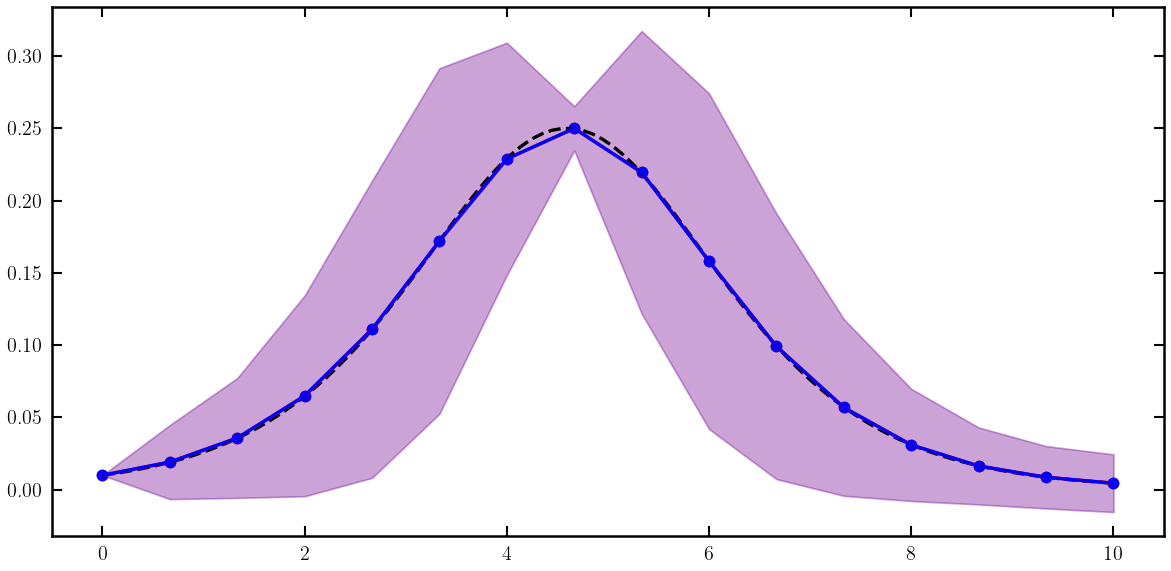

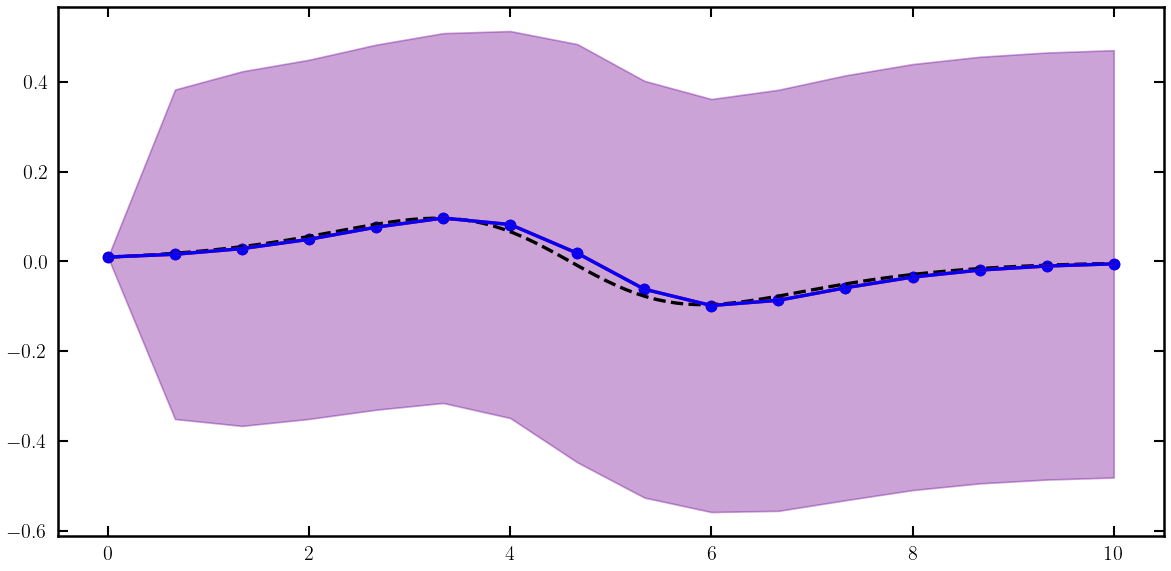

In [34]:
for k in range(3):
    plot_graph2(ts, m_sequence[:,k], P_sequence[:,k,k],m_sequence2[:,k], P_sequence2[:,k,k], t, exact_sols[k])

### Smooth the filtered results


In [35]:
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

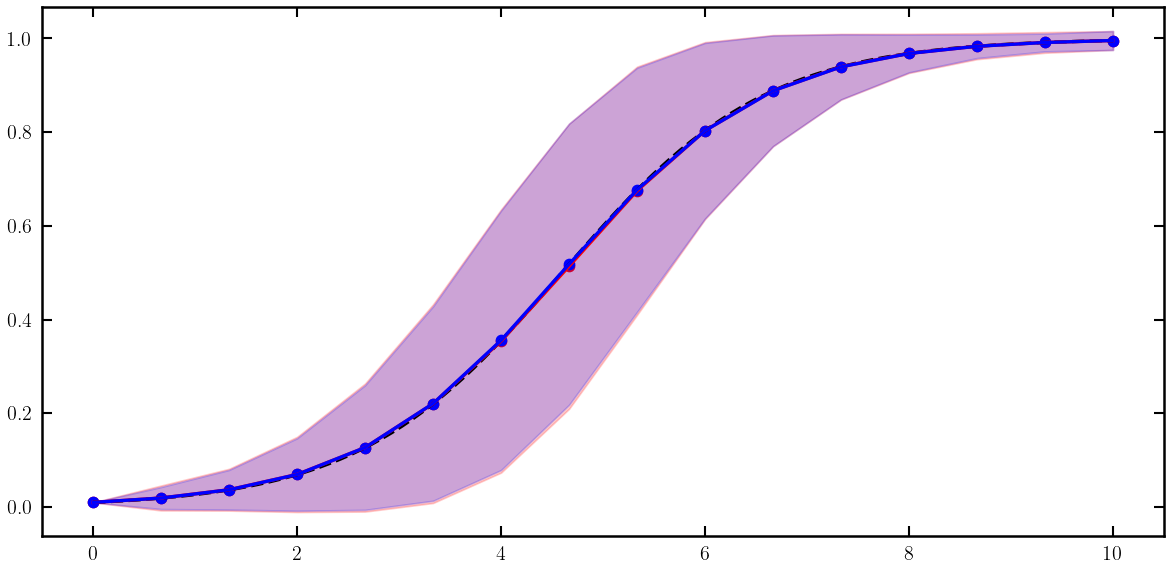

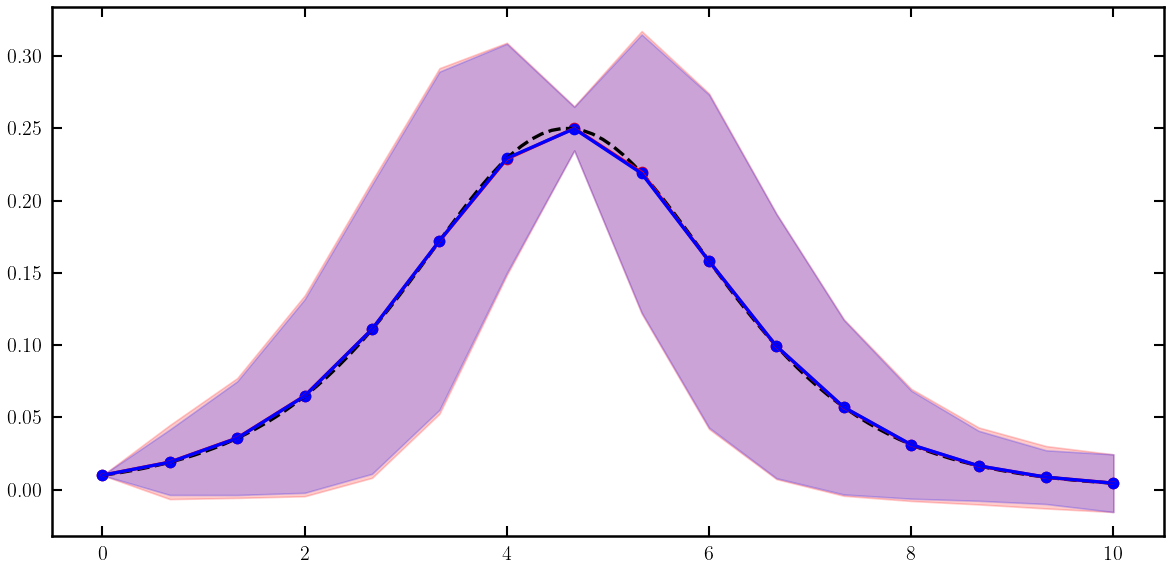

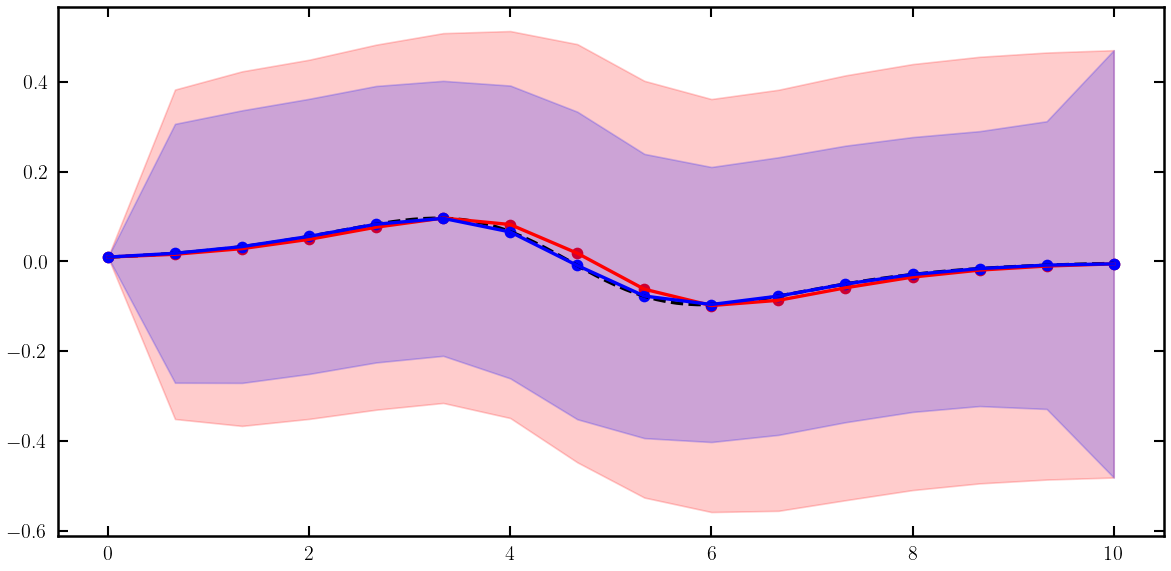

In [36]:
for k in range(3):
    plot_graph2(ts, m_sequence[:,k], P_sequence[:,k,k],m_smoothed[:,k], P_smoothed[:,k,k], t, exact_sols[k])

In [37]:
def plot_ax(ts, m, P, t, x_exact, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts, m, color='red', marker='o', label="filtered estimate")
    #ax.scatter(ts, m, color='red', label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = np.sqrt(P_f_safe)
    ax.fill_between(ts, m - margin, m + margin, alpha=0.2, color='red', label=f'$\pm 1\sigma$')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/7x/8rk5f_057bxdbtdkhq27866m0000gn/T/ipykernel_67306/835224672.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax.fill_between(ts, m - margin, m + margin, alpha=0.2, color='red', label=f'$\pm 1\sigma$')


In [38]:
zs = m_sequence[:,1] - m_sequence[:,0]*(1 - m_sequence[:,0])
# Uncertainty via linearization
zf_var = []
for k in range(m_sequence.shape[0]):
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)
zf_var = np.maximum(np.array(zf_var).reshape(-1), 0)

In [39]:
zf_var.shape

(16,)

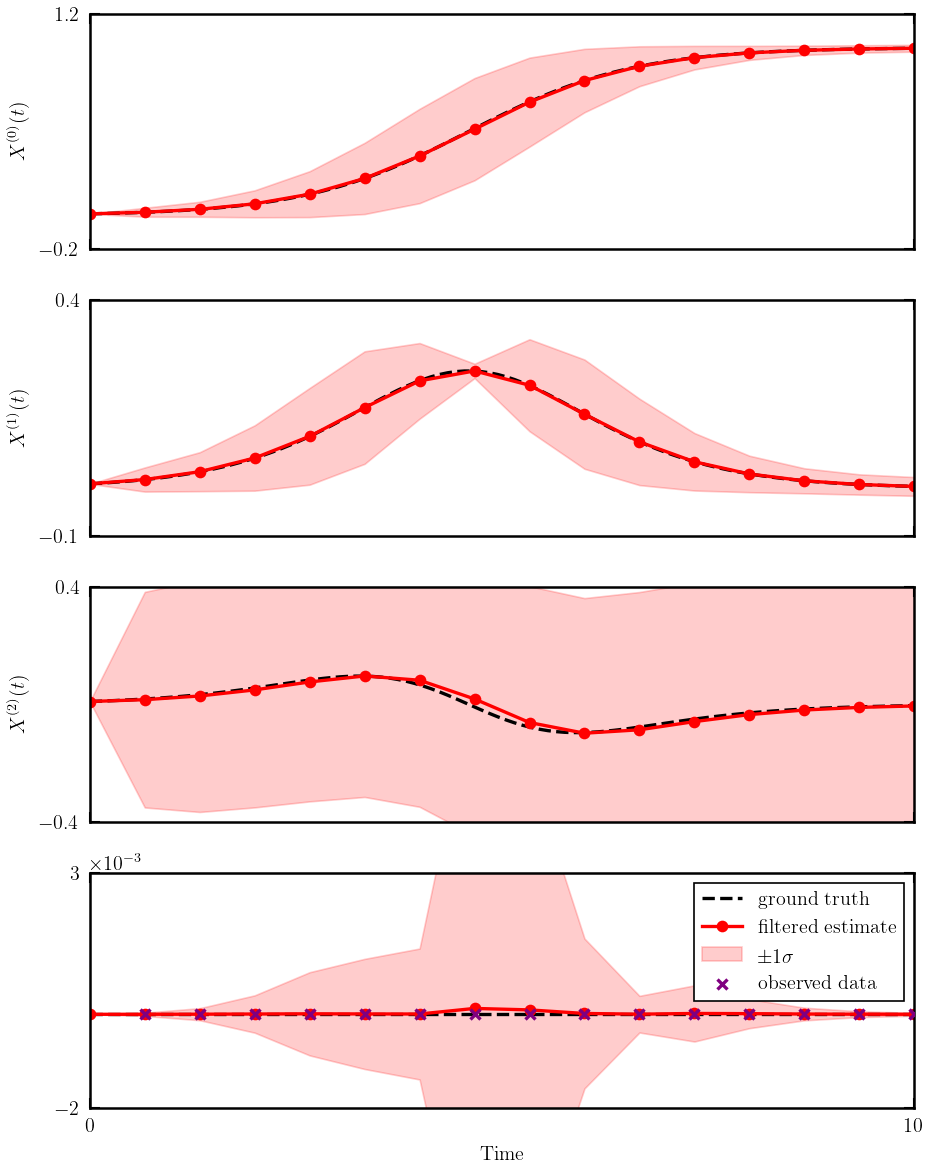

In [46]:

fig, axs = plt.subplots(4, 1, figsize=(8,10), sharex=True)
plot_ax(ts, m_sequence[:,0], P_sequence[:,0,0], t, exact_sols[0], x_lim=[0,10], y_lim=[-0.2,1.2], ax=axs[0])
plot_ax(ts, m_sequence[:,1], P_sequence[:,1,1], t, exact_sols[1], x_lim=[0,10], y_lim=[-0.1, 0.4], ax=axs[1])
plot_ax(ts, m_sequence[:,2], P_sequence[:,2,2], t, exact_sols[2], x_lim=[0,10], y_lim=[-0.4, 0.4], ax=axs[2])

for i in range(3):
    # Styling to match other helper
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_xticks([ts[0], ts[-1]])
    axs[i].set_xticklabels([])
    axs[i].set_xlabel('')
    axs[i].grid(False)

plot_ax(ts, zs, zf_var, t, np.zeros_like, x_lim=[0,10], y_lim=[-0.002, 0.003], ax=axs[-1])
axs[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs[-1].scatter(ts[1:], z_sequence, label="observed data", marker='x', color='purple', zorder=10)
axs[-1].legend()
axs[-1].set_xlabel("Time")
axs[-1].set_xticklabels([0,10])


plt.tight_layout()
plt.show()